# Predicting Property Values 

## Executive Summary

The goal of this analysis is to acquire Zillow data regarding single unit property values from 2017, cleaning and analyzing it to create supervised Machine Learning models. These models were used to predict property tax values of single unit properties that the tax district assesses using the property data from those with a transaction during the "hot months" (in terms of real estate demand) of May-August, 2017.

I also utilized information from the Zillow data to calculate tax rate and its distribution by counties.

### Project Overview

- The tasks for my project were planned using this Trello board
- Python scripts were used to automate the process of acquiring, preparing and exploring the data
- The data was cleaned by replacing null values, dropping duplicates, encoding new features, one hot encoding features
    - These steps were taken to create the best performing model
- Outliers in the data were analyzed as well as the distributions of variables explored in depth
- Statistical analyses tested the following hypotheses:
    - Tax value of homes with more than 3 bathrooms is greater than overall mean tax value (t-test)
    - Is there a linear correlation between number of bedrooms and tax value (pearson's correlation test)
- The data was split into train, test and split dataframes before modeling to avoid data leakage and maintain data integrity
- Recursive feature engineering was utilized to select the top 5 features to be included in the models used to predict property values. 
- Since our target variable, tax value, is continuous, we used the following regression algorithms to create models with the intention of beating the baseline:
    - OLS Regression
    - Lasso + Lars 
    - Tweedie Regressor GLM 
    - Polynomial Regression 
- The best model was fitted on the test data to predict property values

### Key Takeaways

- The square footage, location (latitude and longitude) and number of bedrooms were found to be the best drivers of tax value
- Some variables like number of bedrooms and bathrooms were highly correlated with each other 
- Age of home did not seem to have a significant impact on the tax value of the properties
- There were some outliers in the data in square footage and number of bedrooms and bathrooms 
    - These were handled by using a Robust Scaler to reduce the effect of outliers on the model's performance
- The baseline mean was utilized as the RMSE to beat
    - All models beat this RMSE 
- The RMSE and R squared were utilized as metrics to evaluate models performance
    - My best model's RMSE and R squared were:

### Data Dictionary

- You can find the data dictionary detailing all the variables used and created here.

## Imports that will be utilized throughout this notebook

In [49]:
import pandas as pd
import numpy as np
import env
import matplotlib.pyplot as plt
import seaborn as sns

# custom module imports
import acquire
import prepare
import explore

# feature selection imports
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE

# import scaling methods
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, QuantileTransformer
from scipy import stats

# import modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score

# import to remove warnings
import warnings
warnings.filterwarnings("ignore")

## Acquire Data

The data was acquired from the Codeup database using the following SQL query. The goal was to focus only on single unit properties with a transaction in the hot months. For this analysis, a single unit property is defined as **a housing unit within a larger structure that can be used by an individual or household to eat, sleep, and live. The unit can be in any type of residence, such as a house, apartment, or mobile home, and may also be a single unit in a group of rooms.**

Some columns were renamed during acquisition to make variable names more descriptive. Transaction dates were filtered to be only during the hot months of May to August 2017 as well as property land use types to only include single unit properties. 

    SELECT parcelid, latitude, longitude, fips AS county, yearbuilt, bathroomcnt AS num_baths, bedroomcnt AS num_beds, calculatedfinishedsquarefeet AS num_sqft,propertylandusedesc AS property_desc, taxvaluedollarcnt AS tax_value         
    FROM properties_2017
        JOIN predictions_2017 USING (parcelid)
        JOIN propertylandusetype USING (propertylandusetypeid)
    WHERE transactiondate BETWEEN "2017-05-01" AND "2017-08-31"
    AND propertylandusetypeid IN (261, 263, 264, 265, 266, 268, 273, 275, 276, 279);

In [50]:
# acquiring the zillow data into a dataframe
df = acquire.get_zillow_data()

In [51]:
# quick look at data and the columns
df.head()

,parcelid,latitude,longitude,county,yearbuilt,num_baths,num_beds,num_sqft,property_desc,tax_value
0,14634203,33922098.0,-117954970.0,6059.0,1974.0,2.0,3.0,1125.0,Condominium,289445.0
1,11721753,34033180.0,-118355396.0,6037.0,1923.0,2.0,3.0,1316.0,Single Family Residential,205123.0
2,11289917,34686163.0,-118113100.0,6037.0,1970.0,2.0,3.0,1458.0,Single Family Residential,136104.0
3,11637029,34073222.0,-118390965.0,6037.0,1980.0,2.0,3.0,1766.0,Condominium,810694.0
4,11705026,33999877.0,-118291863.0,6037.0,1911.0,1.0,2.0,1421.0,Single Family Residential,35606.0


In [4]:
# Check the different classes in each variable
df.nunique()

parcelid         38566
latitude         33521
longitude        32140
county               3
yearbuilt          131
num_baths           20
num_beds            13
num_sqft          4191
property_desc        6
tax_value        28451
dtype: int64

### Takeaways

- Displaying value_counts for the following will be helpful:
    - `county`
    - `num_baths`
    - `num_beds`
    - `property_desc`
- Other variables besides the above seem to be continuous

In [4]:
# summarize the df and its columns
acquire.get_data_summary(df)

The zillow dataframe has 38598 rows and 10 columns.

-------------------
There are total of 220 missing values in the entire dataframe.

-------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38598 entries, 0 to 38597
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   parcelid       38598 non-null  int64  
 1   latitude       38598 non-null  float64
 2   longitude      38598 non-null  float64
 3   county         38598 non-null  float64
 4   yearbuilt      38477 non-null  float64
 5   num_baths      38598 non-null  float64
 6   num_beds       38598 non-null  float64
 7   num_sqft       38500 non-null  float64
 8   property_desc  38598 non-null  object 
 9   tax_value      38597 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 2.9+ MB

-------------------
Here are the summary statistics of our dataset
           parcelid      latitude     longitude        county     yearbuilt 

### Acquire Takeaways

- The dataframe has a nice set of observations and not too many columns
- Tax value is our target variable
- Some null values which we will explore and decide how to handle
- parcel id column does not provide much information exceot serving as a unique id for each row so it will be dropped
- The `yearbuilt` column seems to have the most missing values
- All variables except `property_desc` are numeric
- County can be dummy coded because there are 3 categories
- Encode property_desc to convert it from a string to float
- Encode yearbuilt as age of home to make it a continuous variable
- Median year built is 1971
    - Newest home was built in 2016 while the oldest home is from 1878
- Average number of baths around 2 
- Average number of beds around 3
- Min number of beds and baths 0 
    - 0 beds could be a studio but 0 baths is likely an error that will be further explored 
- Mean home size is around 1700 square feet
- Average tax value is around 490,000 USD
- Min tax value is 1,000 USD which must be an error because it is very unlikely to find a property in one of these counties for 1000
- Median tax value is around 300k but max tax value is almost 24 million USD
- About 62% properties are in county 6037 
- More than 70% properties are single family homes and 26% condos

## Prepare Data

During this phase of the pipeline, the main focus was on cleaning and preparing the data for analysis and modeling. 

Functions from my prepare script were utilized to perform the following actions:

- dropping duplicate rows
- encoding `property_desc` to numeric
- encoding `yearbuilt` as `age_of_home`
- One hot encoding the `county` column to 3 different columns
- Splitting the dataframe into train, test and split tests

### Exploring Univariate Distributions
The explore_univariate function from my explore script is used to create bar plots for categorical variables and histograms for quantitative variables

In [5]:
df.columns.to_list()

['parcelid',
 'latitude',
 'longitude',
 'county',
 'yearbuilt',
 'num_baths',
 'num_beds',
 'num_sqft',
 'property_desc',
 'tax_value']

In [52]:
cat_vars = ['county','property_desc']
quant_vars = ['latitude','longitude', 'yearbuilt', 'num_baths',
             'num_beds','num_sqft','tax_value' ]

Bar Plot of county


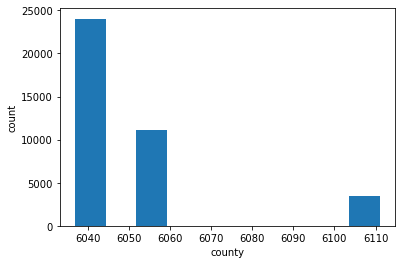

Bar Plot of property_desc


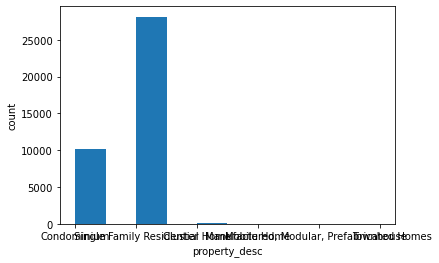

Distribution of latitude


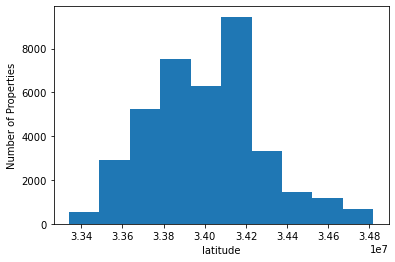

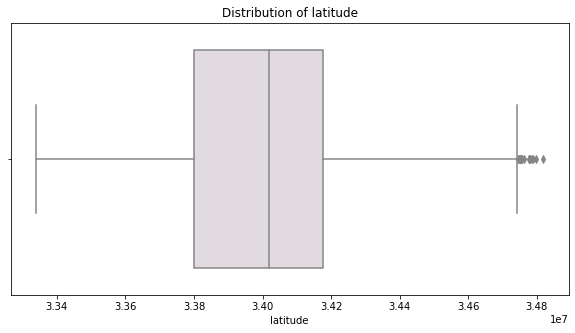

Distribution of longitude


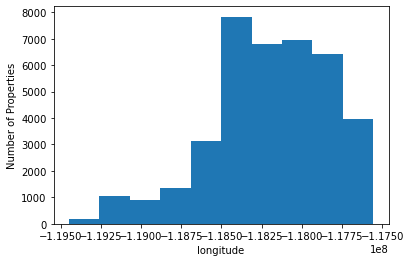

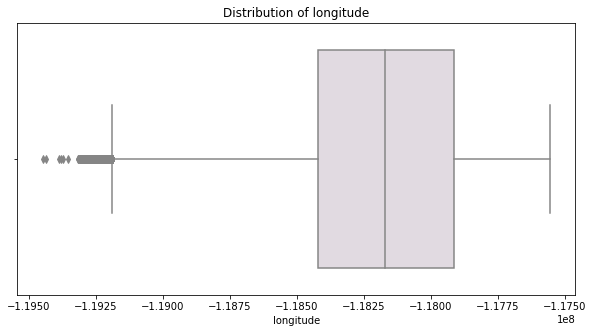

Distribution of yearbuilt


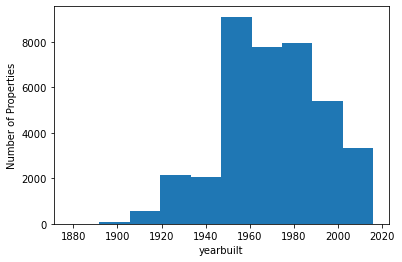

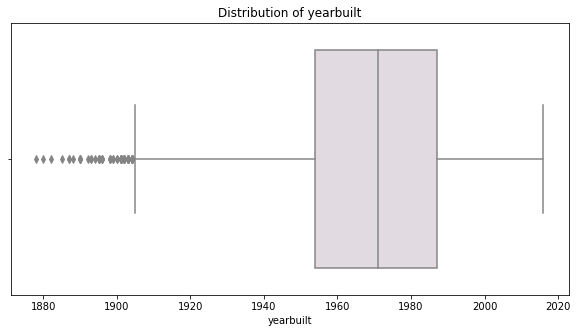

Distribution of num_baths


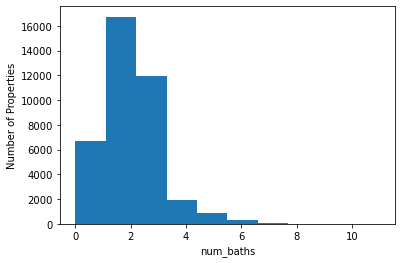

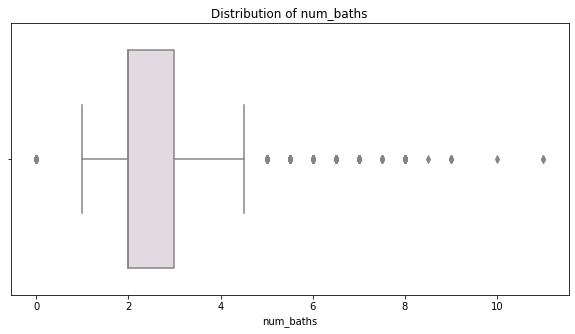

Distribution of num_beds


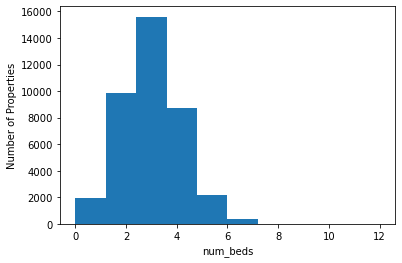

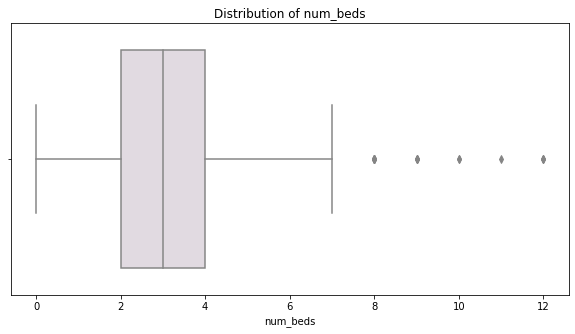

Distribution of num_sqft


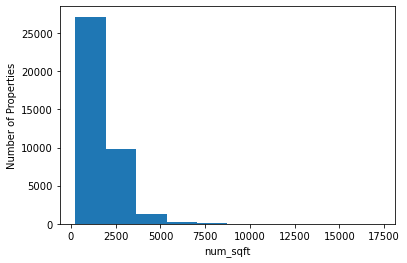

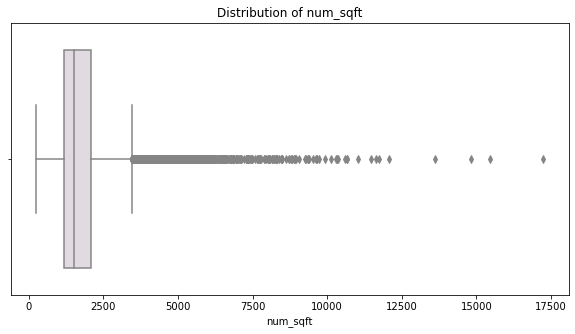

Distribution of tax_value


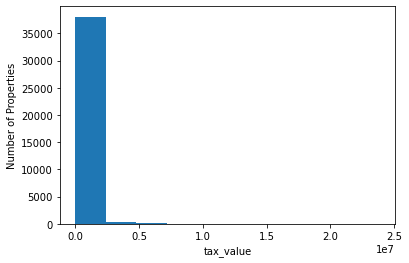

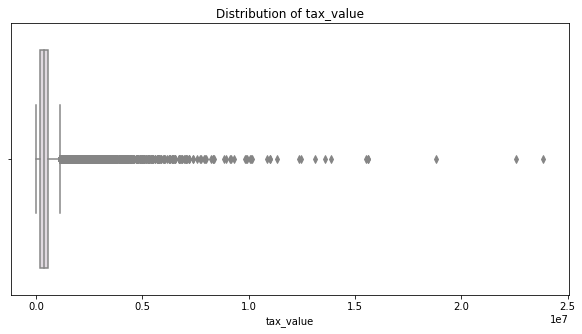

In [5]:
explore.explore_univariate(df, cat_vars, quant_vars)

### Univariate Exploration Takeaways

- Most properties in county 6037 
- Single family homes are most prevalent followed by condos
- Distribution of `latitude` looks quite normal but there are some outliers on the right
- `longitude` and `yearbuilt` have some outliers causing their distributions to be more left skewed
    - most propeorties were built in 1950 to 1990
- Distribution of `num_baths` is more right skewed possibly due to outliers
- While `num_beds` also has some outliers, its distribution looks roughly normal
- The distribution of `num_sqft` is right skewed possibly due to many outliers
    - Most homes are smaller
- The distirbution of our target `tax_value` is also quite right skewed 
    - There seem to be many outliers too 
    - Most values fall in the lower range

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38598 entries, 0 to 38597
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   parcelid       38598 non-null  int64  
 1   latitude       38598 non-null  float64
 2   longitude      38598 non-null  float64
 3   county         38598 non-null  float64
 4   yearbuilt      38477 non-null  float64
 5   num_baths      38598 non-null  float64
 6   num_beds       38598 non-null  float64
 7   num_sqft       38500 non-null  float64
 8   property_desc  38598 non-null  object 
 9   tax_value      38597 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 2.9+ MB


### Handling Missing Values

As identified after summarizing the data, the following columns have missing values which we will now explore further.

- `yearbuilt` 
- `num_sqft`
- `tax_value`

- Since `tax_value` has only one missing value, let\'s start with that!


In [53]:
# find the row with the missing value
df[df.tax_value.isnull()]

,parcelid,latitude,longitude,county,yearbuilt,num_baths,num_beds,num_sqft,property_desc,tax_value
29009,14006983,33792921.0,-117982046.0,6059.0,1954.0,2.0,4.0,1197.0,Single Family Residential,NaN


- It looks like the missing tax value is for a single family property in county 6059 with 4 beds and 2 baths built in 1954. We will filter the df to find other similar properties and their tax values to decide how to fill our missing tax value.

In [54]:
# find other similar properties
df[(df.county == 6059.0) & (df.num_baths == 2.0) & (df.num_beds == 4.0) & (df.property_desc == 'Single Family Residential') 
   & (df.yearbuilt == 1954)].head()

,parcelid,latitude,longitude,county,yearbuilt,num_baths,num_beds,num_sqft,property_desc,tax_value
784,14241527,33786178.0,-117877595.0,6059.0,1954.0,2.0,4.0,1517.0,Single Family Residential,59397.0
1289,13882107,33820510.0,-117928555.0,6059.0,1954.0,2.0,4.0,1455.0,Single Family Residential,278712.0
1733,14274916,33646729.0,-117934779.0,6059.0,1954.0,2.0,4.0,1237.0,Single Family Residential,52388.0
1763,13881990,33823947.0,-117926442.0,6059.0,1954.0,2.0,4.0,1219.0,Single Family Residential,323616.0
2482,13910385,33862377.0,-117961673.0,6059.0,1954.0,2.0,4.0,1944.0,Single Family Residential,66705.0


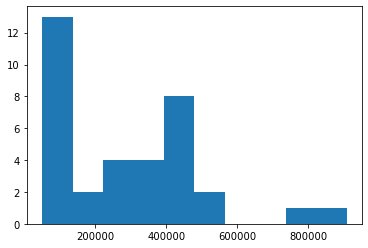

In [8]:
# visualize distribution of similar properties' tax value
df.tax_value[(df.county == 6059.0) & (df.num_baths == 2.0) & (df.num_beds == 4.0) & (df.property_desc == 'Single Family Residential') 
   & (df.yearbuilt == 1954)].hist()
plt.grid(False)

- Since this distribution has some outliers and the median is resistant to outliers we will replace missing tax_value with median for similar properties instead of mean.

In [55]:
# find median tax value only using similar properties
median_tv = df.tax_value[(df.county == 6059.0) & (df.num_baths == 2.0) & (df.num_beds == 4.0) & (df.property_desc == 'Single Family Residential') 
   & (df.yearbuilt == 1954)].median()
median_tv

274539.0

In [56]:
# replace the missing value in df with the above calculated median tax value
df['tax_value'] = df['tax_value'].replace(np.NaN, median_tv)

In [57]:
# confirm changes applied by filtering for that exact parcelid
df[df.parcelid == 14006983]

,parcelid,latitude,longitude,county,yearbuilt,num_baths,num_beds,num_sqft,property_desc,tax_value
29009,14006983,33792921.0,-117982046.0,6059.0,1954.0,2.0,4.0,1197.0,Single Family Residential,274539.0


- Yes, looks like the median tax_value is now the tax_value for that propeorty

- Now we will handle the missing values for `num_sqft`

In [58]:
# find rows where the num_sqft is missing 
df[df.num_sqft.isnull()]

,parcelid,latitude,longitude,county,yearbuilt,num_baths,num_beds,num_sqft,property_desc,tax_value
73,14430658,33464871.0,-117708857.0,6059.0,NaN,0.0,0.0,NaN,Single Family Residential,5346951.0
445,14466991,33597199.0,-117576672.0,6059.0,NaN,0.0,0.0,NaN,Single Family Residential,2493444.0
1308,13972530,33733831.0,-117924909.0,6059.0,NaN,0.0,0.0,NaN,Single Family Residential,270009.0
1310,14325627,33582620.0,-117827925.0,6059.0,NaN,0.0,0.0,NaN,Single Family Residential,7074075.0
1332,12686981,33788953.0,-118402894.0,6037.0,NaN,0.0,0.0,NaN,Single Family Residential,5461875.0
1582,11637994,34078100.0,-118391000.0,6037.0,NaN,0.0,0.0,NaN,Condominium,253812.0
2326,10746614,34132021.0,-118815319.0,6037.0,NaN,0.0,0.0,NaN,Mobile Home,230876.0
2696,14620727,33569391.0,-117720928.0,6059.0,NaN,0.0,0.0,NaN,Condominium,270460.0
3560,14175690,33906400.0,-117879000.0,6059.0,NaN,0.0,0.0,NaN,Mobile Home,157074.0
3657,12131538,34163945.0,-118053754.0,6037.0,NaN,0.0,0.0,NaN,Single Family Residential,225126.0


- Most properties with missing num_sqft values are either single family, condos or mobile homes.

> As identified earlier in the acquire stage, most of these properties with missing square footage values have 0 beds and 0 bathrooms which is highly unlikely especially considering the property types. These values are likely invalid/erroneous so first we will handle these.

In [59]:
# find rows with 0 beds and 0 baths
df[['num_beds', 'num_baths']][(df.num_baths == 0.0) & (df.num_beds == 0.0)].count()

num_beds     130
num_baths    130
dtype: int64

- There are 130 properties with 0 bedrooms and 0 bathrooms. These will be removed from the df.

In [60]:
# find homes that have either 0 beds o 0 baths
df[(df.num_baths == 0.0) | (df.num_beds == 0.0)]


,parcelid,latitude,longitude,county,yearbuilt,num_baths,num_beds,num_sqft,property_desc,tax_value
10,11696784,33991632.0,-118328848.0,6037.0,NaN,0.0,0.0,1378.0,Single Family Residential,168828.0
73,14430658,33464871.0,-117708857.0,6059.0,NaN,0.0,0.0,NaN,Single Family Residential,5346951.0
309,11787436,34050700.0,-118247000.0,6037.0,1899.0,1.0,0.0,740.0,Single Family Residential,188000.0
338,11392193,33982253.0,-118329476.0,6037.0,NaN,0.0,0.0,2276.0,Single Family Residential,101792.0
445,14466991,33597199.0,-117576672.0,6059.0,NaN,0.0,0.0,NaN,Single Family Residential,2493444.0
...,...,...,...,...,...,...,...,...,...,...
38173,12562389,33768400.0,-118185000.0,6037.0,1958.0,1.0,0.0,490.0,Condominium,184923.0
38196,11784726,34045800.0,-118261000.0,6037.0,2006.0,1.0,0.0,660.0,Condominium,442000.0
38264,17190576,34199015.0,-118990825.0,6111.0,1973.0,0.0,0.0,1440.0,"Manufactured, Modular, Prefabricated Homes",201200.0
38464,12553545,33776200.0,-118195000.0,6037.0,1957.0,1.0,0.0,428.0,Condominium,59630.0


- Properties that have 0 beds but at least 1 bath could be studios so those will not be dropped

In [61]:
# removing rows with 0 bed and 0 bath
df = df[(df['num_baths'] > 0) & (df['num_beds'] > 0)]

In [62]:
# confirm changes have been applied
df[['num_beds', 'num_baths']][(df.num_baths == 0.0) & (df.num_beds == 0.0)].count()

num_beds     0
num_baths    0
dtype: int64

- Now, there are no properties with 0 beds and 0 baths!

- Let\'s  see the remaining rows with missing num_sqft

In [63]:
# find rows where num_sqft is still missing
df[df.num_sqft.isnull()]

,parcelid,latitude,longitude,county,yearbuilt,num_baths,num_beds,num_sqft,property_desc,tax_value
4597,10899068,34163400.0,-118379000.0,6037.0,1987.0,2.0,2.0,NaN,Condominium,155392.0
26003,17296474,34103059.0,-118943081.0,6111.0,2004.0,4.5,5.0,NaN,Single Family Residential,1461048.0
33500,14261521,33724734.0,-117900261.0,6059.0,NaN,1.0,1.0,NaN,Single Family Residential,131534.0
33526,14316896,33601262.0,-117876963.0,6059.0,NaN,1.0,1.0,NaN,Single Family Residential,165899.0


- There are 4 rows, the last 2 seem to be very similar property types so first we will handle those. 

In [64]:
# find the mean square footage for properties with similar characteristics as the one with missing num_sqft
avg_1bd = df[(df.property_desc == 'Single Family Residential') & (df.num_baths == 1.0) & (df.num_beds == 1.0)].num_sqft.mean()
avg_1bd

753.1854545454545

In [65]:
# replace missing sqft for 1bed 1 bath homes with avergage 
# sqft of similar properties
df['num_sqft'] = np.where((df.property_desc == 'Single Family Residential') & (df.num_baths == 1.0) & (df.num_beds == 1.0),df['num_sqft'].replace(np.NaN, avg_1bd), df['num_sqft'])

In [66]:
# confirm changes applied

# first row
df[(df.parcelid == 14261521)]


,parcelid,latitude,longitude,county,yearbuilt,num_baths,num_beds,num_sqft,property_desc,tax_value
33500,14261521,33724734.0,-117900261.0,6059.0,NaN,1.0,1.0,753.185455,Single Family Residential,131534.0


In [67]:
# second row where the num_sqft was replaced with mean

df[(df.parcelid == 14316896)]

,parcelid,latitude,longitude,county,yearbuilt,num_baths,num_beds,num_sqft,property_desc,tax_value
33526,14316896,33601262.0,-117876963.0,6059.0,NaN,1.0,1.0,753.185455,Single Family Residential,165899.0


In [68]:
# find remaining rows with nulls in num_sqft column
df[df.num_sqft.isnull()]

,parcelid,latitude,longitude,county,yearbuilt,num_baths,num_beds,num_sqft,property_desc,tax_value
4597,10899068,34163400.0,-118379000.0,6037.0,1987.0,2.0,2.0,NaN,Condominium,155392.0
26003,17296474,34103059.0,-118943081.0,6111.0,2004.0,4.5,5.0,NaN,Single Family Residential,1461048.0


- find similar property to the above two properties with missing num_sqft and calculate the mean square footage to replace missing values with

In [69]:
# avg sqft for the 2bd 2ba condo
avg_2bd = df.num_sqft[(df.property_desc == 'Condominium') & (df.num_baths == 2.0) & (df.num_beds == 2.0)].mean()
avg_2bd

1143.1870121760849

In [70]:
# replace missing value with avg calculated above
df['num_sqft'] = np.where((df.property_desc == 'Condominium') & (df.num_baths == 2.0) & (df.num_beds == 2.0),df['num_sqft'].replace(np.NaN, avg_2bd), df['num_sqft'])

In [71]:
# avg sqft for the 5bd single family home
avg_5bd = df.num_sqft[(df.property_desc == 'Single Family Residential') & (df.num_baths == 4.5) & (df.num_beds == 5.0)].mean()
avg_5bd 

4044.1645569620255

In [72]:
# replace missing value with avg calculated above
df['num_sqft'] = np.where((df.property_desc == 'Single Family Residential') & (df.num_baths == 4.5) & (df.num_beds == 5.0),df['num_sqft'].replace(np.NaN, avg_5bd), df['num_sqft'])

In [73]:
# confirm changes applied to nan values and no more remaining nulls in num_sqft
df[df.num_sqft.isnull()]

,parcelid,latitude,longitude,county,yearbuilt,num_baths,num_beds,num_sqft,property_desc,tax_value


- Handling yearbuilt's missing value

In [74]:
# find rows where yearbuilt is null
df[df.yearbuilt.isnull()]

,parcelid,latitude,longitude,county,yearbuilt,num_baths,num_beds,num_sqft,property_desc,tax_value
2150,11673439,34138236.0,-118598065.0,6037.0,NaN,2.0,2.0,1344.000000,Condominium,305378.0
5525,12270438,33919941.0,-118226166.0,6037.0,NaN,1.0,2.0,736.000000,Single Family Residential,21283.0
6203,12258767,33922648.0,-118273347.0,6037.0,NaN,3.0,3.0,1310.000000,Single Family Residential,319000.0
6859,17212610,34205891.0,-118882808.0,6111.0,NaN,3.0,5.0,3800.000000,Single Family Residential,605142.0
7911,17225655,34229721.0,-118792509.0,6111.0,NaN,4.5,6.0,4103.000000,Single Family Residential,939970.0
9622,17086167,34255850.0,-119269049.0,6111.0,NaN,2.0,3.0,1163.000000,Single Family Residential,317286.0
9687,17268164,34197102.0,-118894370.0,6111.0,NaN,2.5,3.0,2764.000000,Single Family Residential,549573.0
10140,17282979,34189723.0,-118857501.0,6111.0,NaN,2.5,3.0,2516.000000,Single Family Residential,204638.0
11755,17072011,34281197.0,-119228656.0,6111.0,NaN,3.5,4.0,3574.000000,Single Family Residential,582991.0
12078,10998967,34254513.0,-118317418.0,6037.0,NaN,3.0,3.0,1964.000000,Single Family Residential,573616.0


- The observations that are missing yearbuilt values don't have missing values in any other columns
- There are 27 rows with missing values for yearbuilt
- There is not a specific property type that is missing the yearbuilt value so we will visualize the variable's distribution and decided whether to replace with mean or median yearbuilt.

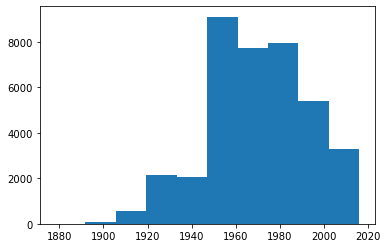

In [75]:
# visualize distribution of year built
df.yearbuilt.hist()
plt.grid(False)

- The distribution is left skewed so we will proceed with using the median instead of the mean since median is more resistant to outliers.

In [76]:
# find median year built in df
df.yearbuilt.median()

1971.0

In [77]:
# create imputer to replace missing year built with median 
from sklearn.impute import SimpleImputer

def impute_median(df):
    '''
    This function takes in a dataframe and imputes median for the yearbuilt column. 
    It then replaces missing values with median yearbuilt value.
    '''
    imputer = SimpleImputer(strategy='median', missing_values=np.nan)
    df[['yearbuilt']] = imputer.fit_transform(df[['yearbuilt']])
    return df

In [78]:
# call the function to replace yearbuilt missing values
impute_median(df)

,parcelid,latitude,longitude,county,yearbuilt,num_baths,num_beds,num_sqft,property_desc,tax_value
0,14634203,33922098.0,-117954970.0,6059.0,1974.0,2.0,3.0,1125.0,Condominium,289445.0
1,11721753,34033180.0,-118355396.0,6037.0,1923.0,2.0,3.0,1316.0,Single Family Residential,205123.0
2,11289917,34686163.0,-118113100.0,6037.0,1970.0,2.0,3.0,1458.0,Single Family Residential,136104.0
3,11637029,34073222.0,-118390965.0,6037.0,1980.0,2.0,3.0,1766.0,Condominium,810694.0
4,11705026,33999877.0,-118291863.0,6037.0,1911.0,1.0,2.0,1421.0,Single Family Residential,35606.0
...,...,...,...,...,...,...,...,...,...,...
38593,14453399,33468267.0,-117578817.0,6059.0,2002.0,3.0,5.0,3015.0,Single Family Residential,852813.0
38594,12019061,34092100.0,-118377000.0,6037.0,1964.0,2.0,1.0,769.0,Condominium,492395.0
38595,11570288,34050300.0,-118471000.0,6037.0,1969.0,2.0,2.0,1212.0,Condominium,600608.0
38596,11128688,34279343.0,-118554206.0,6037.0,1977.0,3.0,5.0,2992.0,Single Family Residential,1120000.0


In [79]:
# confirm changes applied
df[df.parcelid==11673439]

,parcelid,latitude,longitude,county,yearbuilt,num_baths,num_beds,num_sqft,property_desc,tax_value
2150,11673439,34138236.0,-118598065.0,6037.0,1971.0,2.0,2.0,1344.0,Condominium,305378.0


- Our changes have been applied. As you can see the yearbuilt value for the above observation is no longer null but has been replace by the median value through our imputer function.

In [80]:
# check for any remaining missing values in our df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38343 entries, 0 to 38597
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   parcelid       38343 non-null  int64  
 1   latitude       38343 non-null  float64
 2   longitude      38343 non-null  float64
 3   county         38343 non-null  float64
 4   yearbuilt      38343 non-null  float64
 5   num_baths      38343 non-null  float64
 6   num_beds       38343 non-null  float64
 7   num_sqft       38343 non-null  float64
 8   property_desc  38343 non-null  object 
 9   tax_value      38343 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 3.2+ MB


- It looks like all missing values have been taken care of without dropping rows. Through this action, data loss from those observations in 220 rows has been prevented. The more data we have the better our model can predict. However, since these values have been imputed and replaced by our best guess, it is possible they are not enitrely accurate. 

In [81]:
# call the function from prepare script to perform further data cleaning and prep
df = prepare.prep_zillow(df)

There are 32 duplicate rows in your dataset - these will be dropped.
----------------
There are no rows with null values in your dataset.
----------------


In [82]:
# split the df to prevent data leakage

train, validate, test = prepare.split_zillow(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21453 entries, 2791 to 19575
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   parcelid       21453 non-null  int64  
 1   latitude       21453 non-null  float64
 2   longitude      21453 non-null  float64
 3   county         21453 non-null  float64
 4   yearbuilt      21453 non-null  float64
 5   num_baths      21453 non-null  float64
 6   num_beds       21453 non-null  float64
 7   num_sqft       21453 non-null  float64
 8   property_desc  21453 non-null  object 
 9   tax_value      21453 non-null  float64
 10  property_type  21453 non-null  int64  
 11  age_of_home    21453 non-null  int64  
 12  county_6037    21453 non-null  uint8  
 13  county_6059    21453 non-null  uint8  
 14  county_6111    21453 non-null  uint8  
dtypes: float64(8), int64(3), object(1), uint8(3)
memory usage: 2.2+ MB
----------------
Shape of train split: (21453, 15)
----------------


In [83]:
# quick peak at train split
train.head()

,parcelid,latitude,longitude,county,yearbuilt,num_baths,num_beds,num_sqft,property_desc,tax_value,property_type,age_of_home,county_6037,county_6059,county_6111
2791,14489960,33614725.0,-117670964.0,6059.0,1968.0,2.5,3.0,1618.0,Single Family Residential,631675.0,0,53,0,1,0
34392,17080633,34266662.0,-119254675.0,6111.0,1953.0,2.0,2.0,1291.0,Single Family Residential,505000.0,0,68,0,0,1
9565,14120693,33845477.0,-118034726.0,6059.0,1975.0,2.0,3.0,1526.0,Single Family Residential,626104.0,0,46,0,1,0
16816,12795356,33945097.0,-118040777.0,6037.0,1953.0,1.0,3.0,1103.0,Single Family Residential,327672.0,0,68,1,0,0
28235,17127063,34223858.0,-119076532.0,6111.0,2002.0,2.5,3.0,1657.0,Condominium,406454.0,1,19,0,0,1


### Handling Outliers
- As identified during our initial exploration, some variables contain outliers which will be addressed to see if the distributions become more normal.
- To prevent data leakage we will remove outliers only from our train split.
    - Since the validate and test splits will still contain outliers, this can negatively affect model performance.
- Removing outliers has an impact on the feature's correlation with the target variable. 
- Before removing outliers, look at current correlation of predictors with target. Since outliers are present, we will use Spearman's method which is less sensitive to outliers than Pearson's correlation. 

<AxesSubplot:>

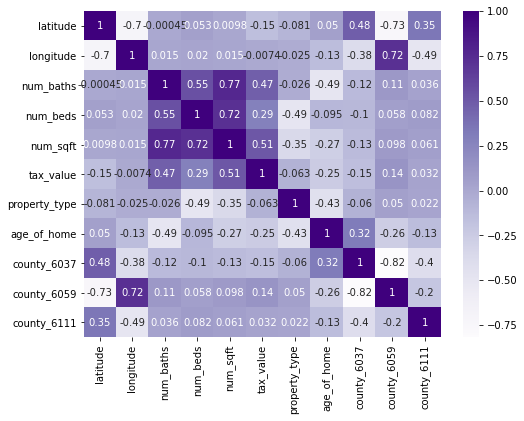

In [84]:
# check correlation with target - drop columns that are unnecessary
tv_corr = train.drop(columns=['parcelid', 'yearbuilt', 'county']).corr(method='spearman')
tv_corr

# visulaize correlation with a heatmap
plt.figure(figsize=(8,6))
sns.heatmap(tv_corr, cmap='Purples', annot=True)

### Heatmap Takeaways

- Highest correlation of num_sqft with target, followed by num_baths and num_beds
- Lowest correlation of longitude with target
- Some features highly correlated with each other
    - num_beds and num_baths have high correlations with num_sqft
    - This could lead to issues with multicollinearity

<AxesSubplot:title={'center':'Correlation of features with target of tax_value'}>

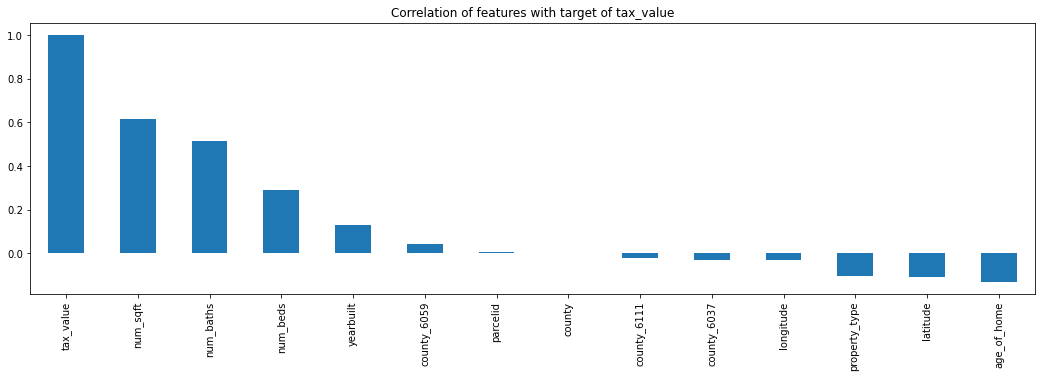

In [85]:
# visualize predictors' correlation with the target variable 
plt.figure(figsize=(15,8))
plt.title('Correlation of features with target of tax_value')
train.corr().tax_value.sort_values(ascending=False).plot(kind='bar', figsize=(18,5))

In [86]:
# remove outliers from train split
outlier_cols = ['num_baths', 'num_beds', 'num_sqft', 'age_of_home', 'tax_value']
new_train = prepare.remove_outliers(train, outlier_cols, 1.5)

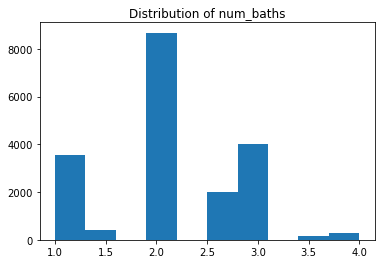

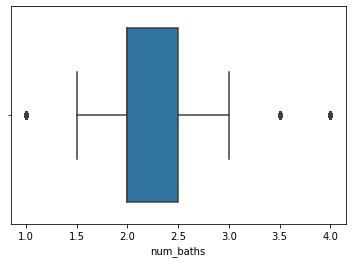

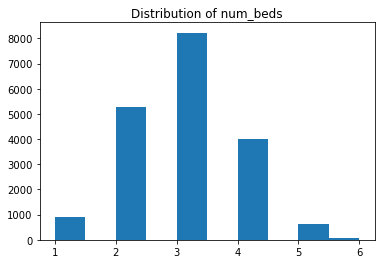

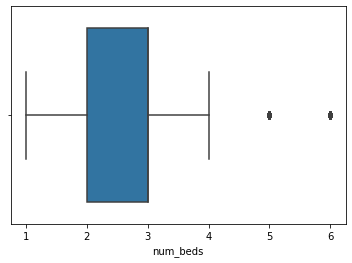

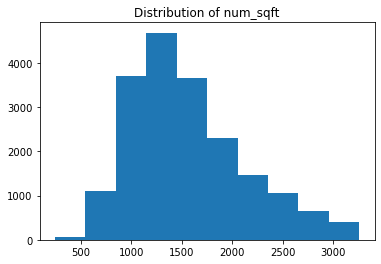

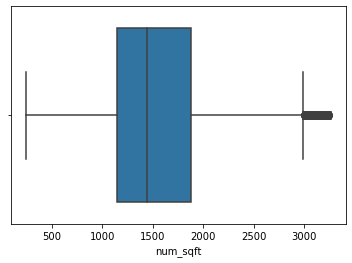

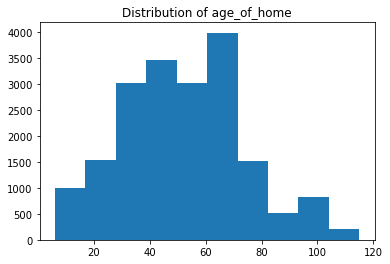

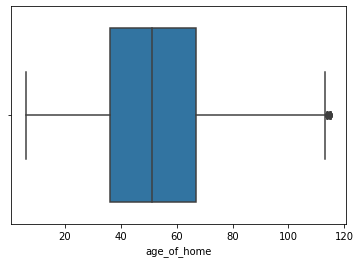

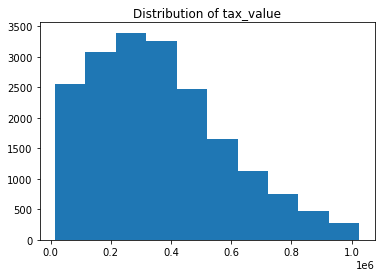

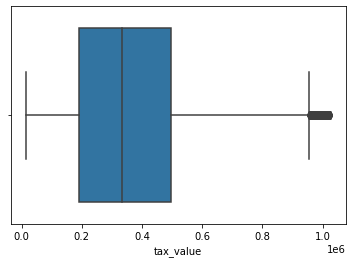

In [87]:
# now that we've removed the outliers, let's replot to see the distributions
for col in outlier_cols:
    new_train[col].hist()
    plt.title('Distribution of ' + col)
    plt.grid(False)
    plt.show()
    sns.boxplot(x=col, data = new_train)
    plt.show()

### Outlier Distribution Takeaways

- Removing outliers shifts the following distributions to slightly normal:
     - num_beds
     - age_of_home 
- However, tax_value and num_sqft still have outliers and skewed distributions

- To check correlation after removing outliers, we will use the default pearson's correlation method.

<AxesSubplot:>

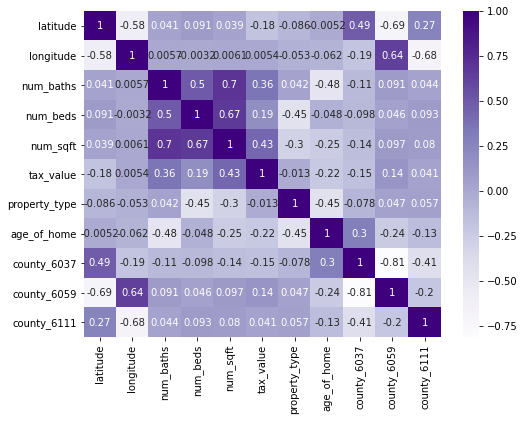

In [88]:
# check correlation with target - drop columns that are unnecessary
tv_corr1 = new_train.drop(columns=['parcelid', 'yearbuilt', 'county']).corr()
tv_corr1

# visulaize correlation with a heatmap
plt.figure(figsize=(8,6))
sns.heatmap(tv_corr1, cmap='Purples', annot=True)

<AxesSubplot:title={'center':'Correlation of features with target of tax_value'}>

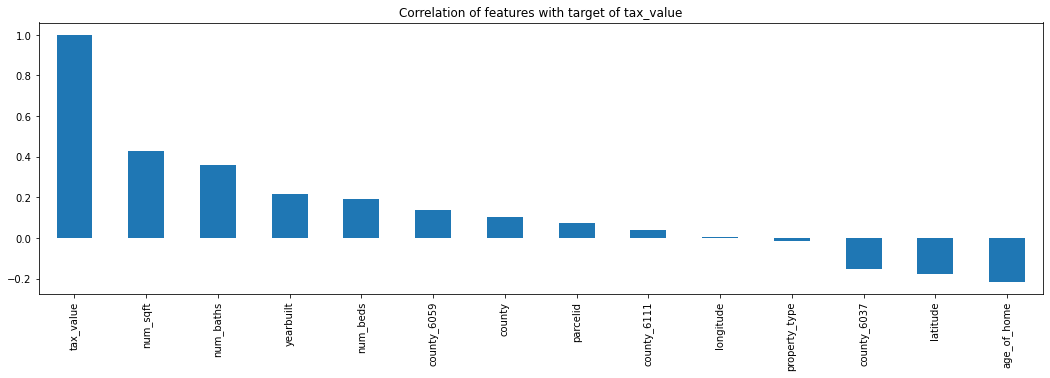

In [89]:
# check correlation with target after removing outliers
plt.title('Correlation of features with target of tax_value')
new_train.corr().tax_value.sort_values(ascending=False).plot(kind='bar', figsize=(18,5))

### Takeaways

- Highest correlation with target is still num_sqft but the correlation is now lower at 0.43 vs 0.51 before removing outliers
- Overall correlations reduced after removing outliers
- The same variables have higher correlations with target after removing outliers
> Since the distributions of variables were not greatly impacted by removing outliers and the correlation of features with target reduced, we will proceed without removing outliers


## Explore Data

### Exploring Bivariate Relationships

This will be performed by utilizing the functions from my explore script to visualize relationships between different variables.

In [90]:
# assign categorical and quantitative variables
cat_vars1 = ['county', 'property_type'] 
quant_vars1 = ['latitude','longitude','age_of_home', 'num_baths',
               'num_beds','num_sqft','tax_value']

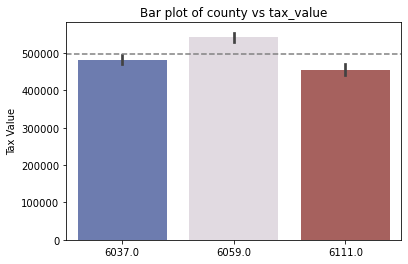

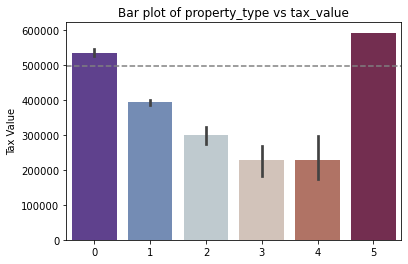

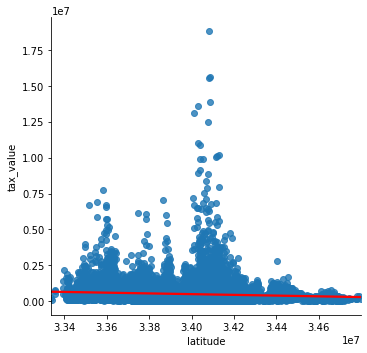

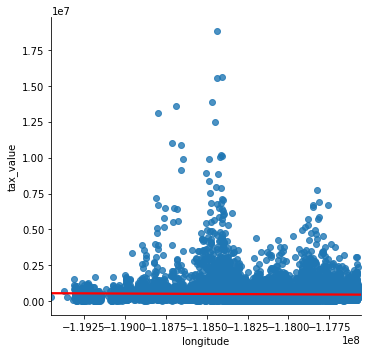

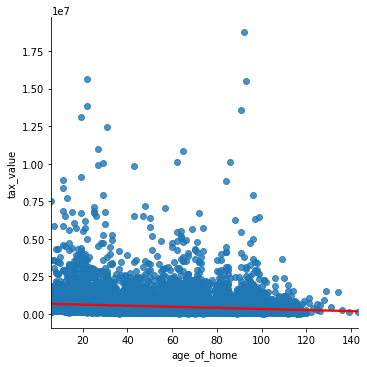

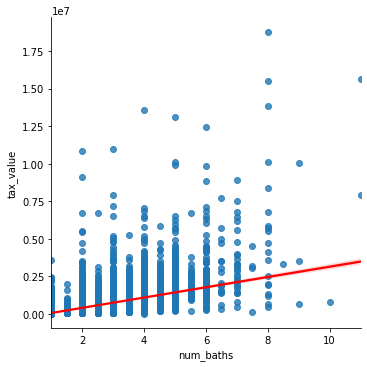

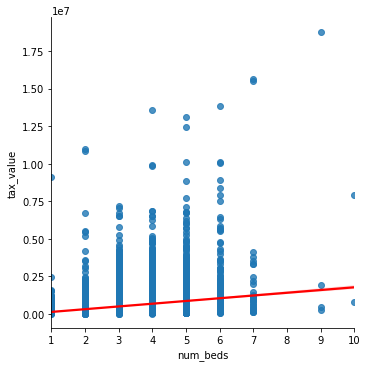

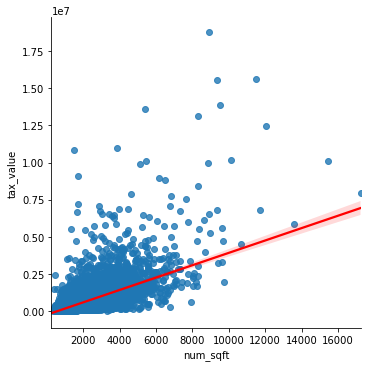

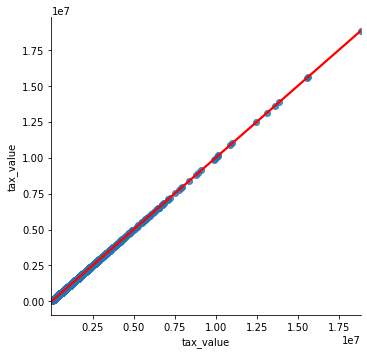

In [91]:
explore.explore_bivariate(train, 'tax_value', cat_vars1, quant_vars1)

### Takeaways

- Tax value of properties in 6059 county is higher than average while other counties have below average tax values
- Highest tax value for property type 5 that is followed by 0, 1, 2 and 3 and 4 have about the same tax values
- On latitude around 3.41 tax values are higher
- Approximately Longitude -1.83 has the highest tax values
- Location affects tax values
- Age of home seems to be more concentrate around the lower tax values
- Age seems to be negatively correlated with tax value 
    - Older properties have lower tax values
- Number of bathrooms seems to have a positive correlation with tax values
    - However, there are a bunch of outliers
        - Some homes with fewer bathrooms have quite high tax values
- A lot of properties have 5 bedrooms
- Square footage has a positive correlation with tax values
    - As the size of a property increases, so does its tax value
    - Most tax values are in the lower range

KeyboardInterrupt: 

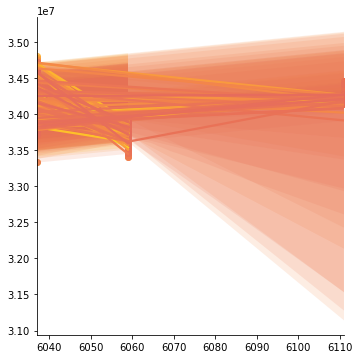

In [92]:
explore.explore_multivariate(train, 'tax_value', cat_vars1, quant_vars1)

In [144]:
def explore_multivariate(train, target, cat_vars, quant_vars):
    '''
    This function takes in takes in a dataframe, the name of the binary target variable, a list of 
    the names of the categorical variables and a list of the names of the quantitative variables.
    It generates boxplots showing the target variable for each class of the categorical variables 
    against the quantitative variables.
    '''
    for cat in cat_vars:
        for quant in quant_vars:
            sns.lmplot(x=quant, y=target, data=train, scatter=True, hue=cat, palette ='colorblind')
            plt.xlabel(quant)
            plt.ylabel(target)
            plt.title(quant + ' vs ' + target + ' by ' + cat)
            plt.show()

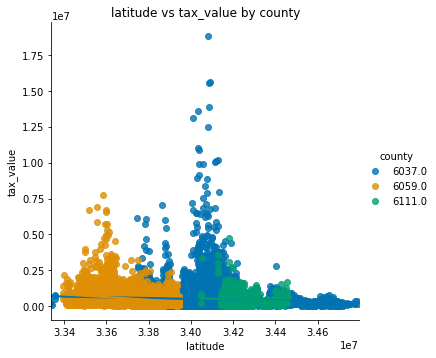

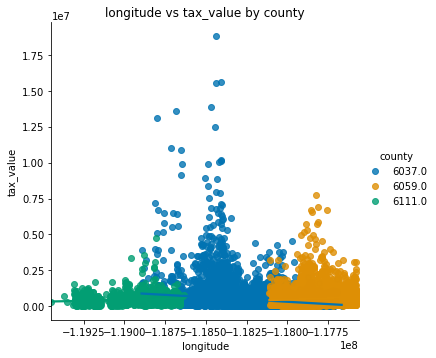

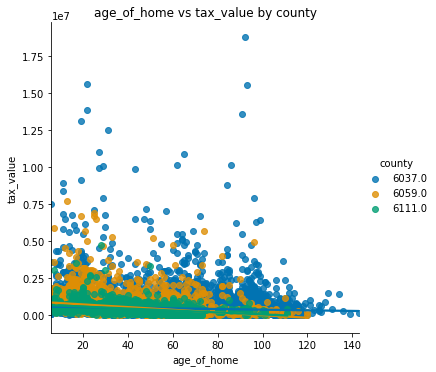

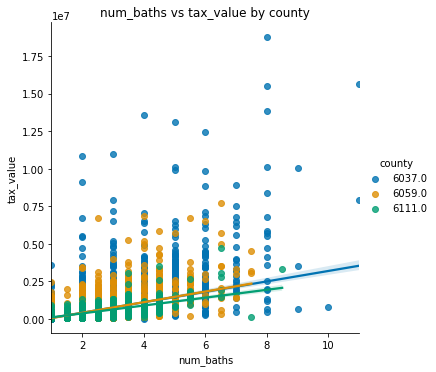

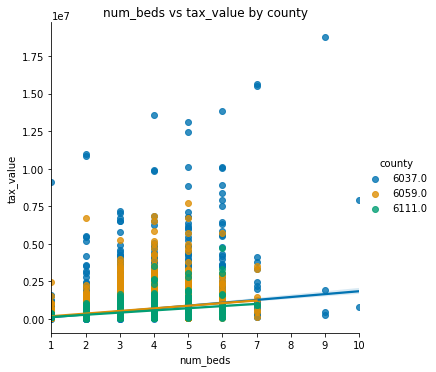

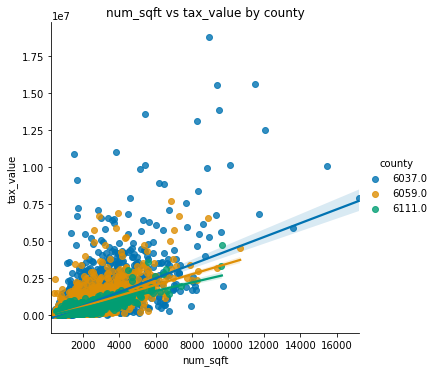

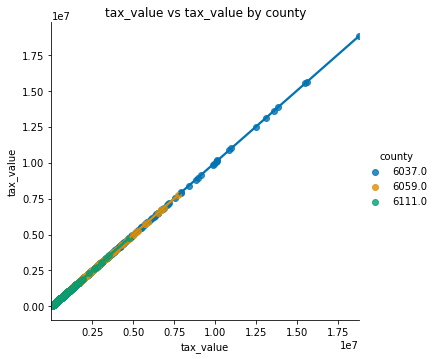

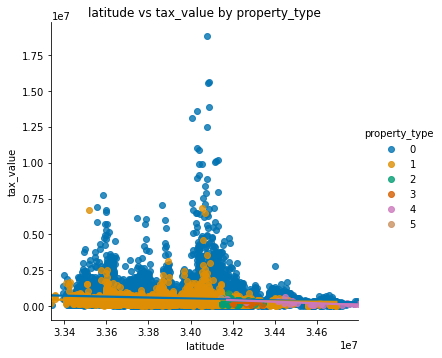

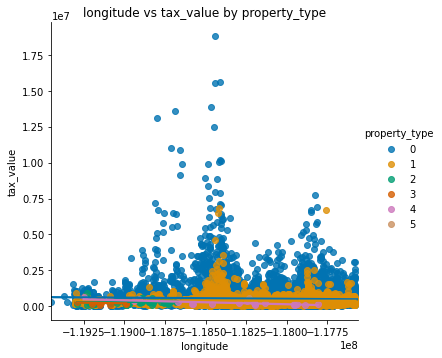

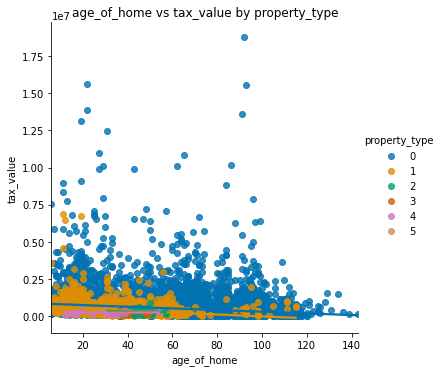

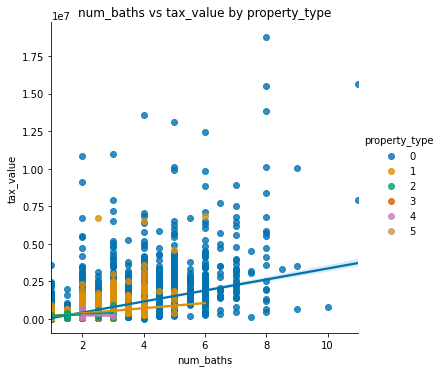

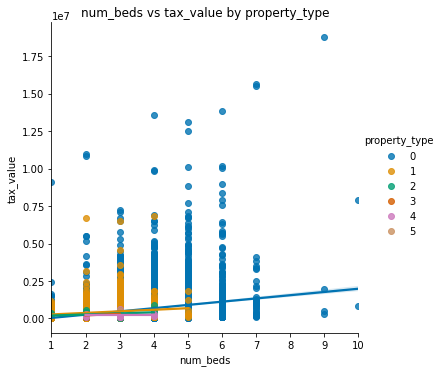

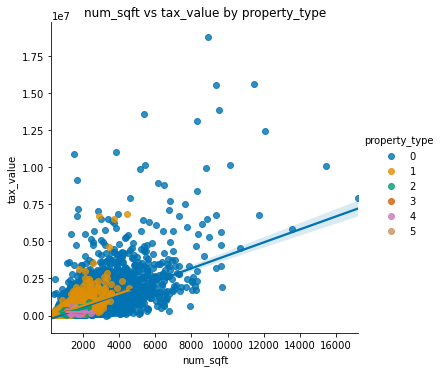

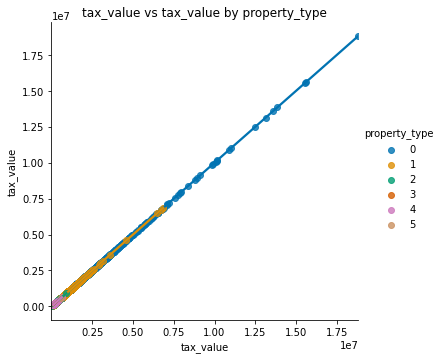

In [145]:
explore_multivariate(train, 'tax_value', cat_vars1, quant_vars1)

### Takeaways

- Tax values are usually in the lower range
- Highest tax values in county 6037 for almost all number of bathrooms and bedrooms
- Homes in county 6037 are also bigger in size
- Single family properties have higher tax values and are also bigger in size than other property types
- Some older homes have very high tax values too 
    - usually as age of home increases, the tax values decrease

###  Visualize how predictors correlate with each other and the target

In [139]:
# select columns to visualize
zillow_cols = ['num_baths', 'num_beds', 'num_sqft', 'tax_value']

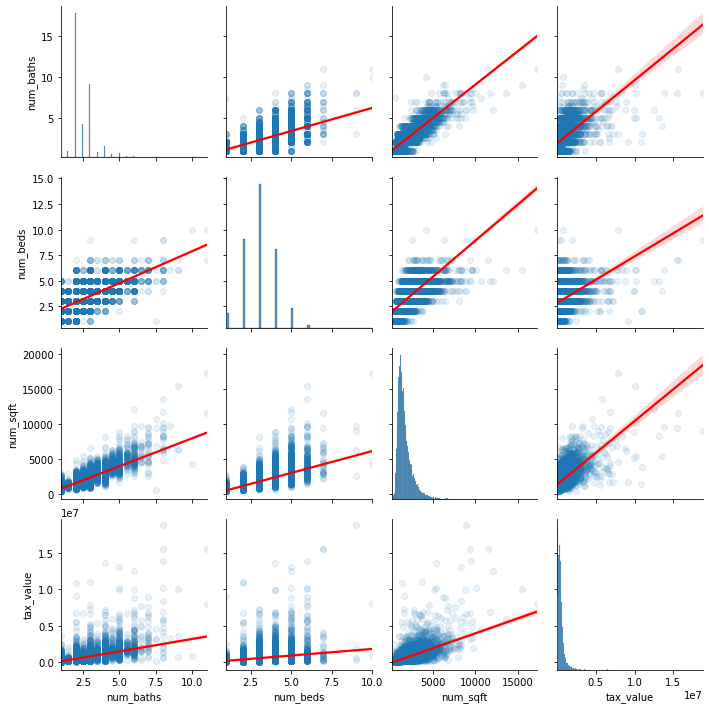

In [141]:
# call function from explore script to visualize
explore.plot_variable_pairs(train,zillow_cols )

### Takeaways

- Number of bedrooms and bathrooms have a positive correlation with square footage as well as tax value
- Strongest positive correlations between number of bathrooms and square footage
- num_sqft seems to have a strong positive correlation with tax_value 
    - This could lead to num_sqft being a good driver of tax_valu

## Statistical Analysis

Based on my EDA, I will be testing the following hypotheses:
    
- Tax value of properties with in county 6059 are higher than overall mean tax value (t- test)
- Is there a linear correlation between age of home and tax value (spearman correlation test)

- For all statistical tests, a confidence level of 0.99 and an alpha of 0.01 will be used.

#### Properties in county 6059

- 1 sample t-test 

For a 1-tailed test where our alternative hypothesis is testing for "greater than", we evaluate 𝑝/2 < 𝛼 and 𝑡 > 0.

- Setting Hypothesis

$H_{0}$: Mean tax value of properties in county 6059 = Mean tax value of all properties

$H_{a}$: Mean tax value of properties in county 6059 > Mean tax value of all properties

- Verify assumptions
Normal distribution

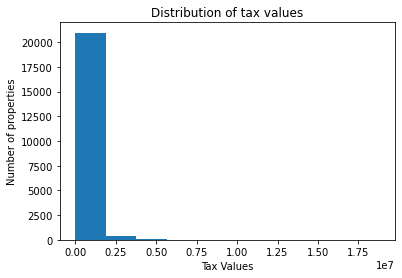

In [146]:
# plot distribution of tax values

plt.title('Distribution of tax values')
plt.xlabel('Tax Values')
plt.ylabel('Number of properties')
plt.hist(train.tax_value)
plt.show()

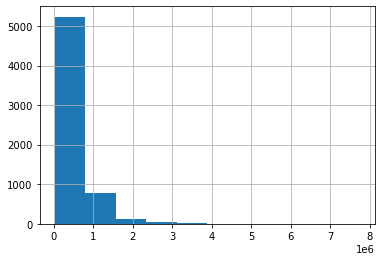

In [156]:
# plot distribution of montly charges for customer who churn

county_6059_tv = train[train.county_6059 == 1].tax_value
county_6059_tv.hist()
# plt.title('Distribution of tax values for county 6059 properties')
# plt.ylabel('Number of properties')
# plt.xlabel('Monthly Charges for ')
plt.grid(False)
plt.show()

In [147]:
train.head()

,parcelid,latitude,longitude,county,yearbuilt,num_baths,num_beds,num_sqft,property_desc,tax_value,property_type,age_of_home,county_6037,county_6059,county_6111
2791,14489960,33614725.0,-117670964.0,6059.0,1968.0,2.5,3.0,1618.0,Single Family Residential,631675.0,0,53,0,1,0
34392,17080633,34266662.0,-119254675.0,6111.0,1953.0,2.0,2.0,1291.0,Single Family Residential,505000.0,0,68,0,0,1
9565,14120693,33845477.0,-118034726.0,6059.0,1975.0,2.0,3.0,1526.0,Single Family Residential,626104.0,0,46,0,1,0
16816,12795356,33945097.0,-118040777.0,6037.0,1953.0,1.0,3.0,1103.0,Single Family Residential,327672.0,0,68,1,0,0
28235,17127063,34223858.0,-119076532.0,6111.0,2002.0,2.5,3.0,1657.0,Condominium,406454.0,1,19,0,0,1


In [149]:
# find the overall mean tax value and mean tax value for props in 6059
mean_tax_val = train.tax_value.mean()
county6059_mean = train[train.county_6059 == 1].tax_value

In [150]:
# perform the test
alpha = 0.01

t, p = stats.ttest_1samp(county6059_mean, mean_tax_val)

t, p/2, alpha

(6.8688984244831595, 3.549389378456319e-12, 0.01)

In [152]:
# check if p value is less than alpha
if (p/2 < alpha) & (t > 0):
    print("We reject the null hypothesis. \nWe move forward with the alternative hypothesis: The tax value for homes in county 6059 is higher than the mean tax value")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis. 
We move forward with the alternative hypothesis: The tax value for homes in county 6059 is higher than the mean tax value


### Age of home 

- Spearman correlation test since it is less sensitive to outliers than pearson's r

- Setting Hypothesis

$H_{0}$: There is no linear correlation between age of property and tax value

$H_{a}$: There is a linear correlation between age of property and tax value

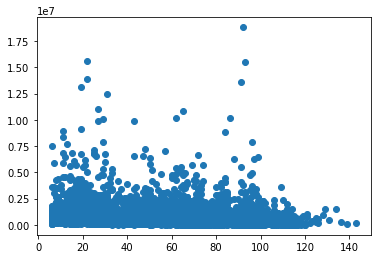

In [153]:
# visualize the distribution
x = train.age_of_home
y = train.tax_value
plt.scatter(x,y)

In [154]:
# this test returns the spearman's correlation r and a p -value
r, p = stats.spearmanr(train.age_of_home, train.tax_value)
r, p, alpha

(-0.24912366478360637, 7.765253601208048e-301, 0.01)

In [155]:
if p < alpha:
    print('''Our p value is less than alpha and we can reject the null hypothesis.
We can suggest there is a linear correlation between age of home and taxvalue''')
else:
    print('We cannot reject the null hypothesis')

Our p value is less than alpha and we can reject the null hypothesis.
We can suggest there is a linear correlation between age of home and taxvalue
